<a href="https://colab.research.google.com/github/daehkim/pair-trading/blob/master/Backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS7641 Machine Learning
*Application of Machine Learning in Pairs Trading*

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt

## Generate the input data

### Price history

Price history will be about only one stock.

In [30]:
total_data = pd.read_csv("training_data.csv")
total_data.head(3)

,PERMNO,price_20070103,price_20070104,price_20070105,price_20070108,price_20070109,price_20070110,price_20070111,price_20070112,price_20070116,price_20070117,price_20070118,price_20070119,price_20070122,price_20070123,price_20070124,price_20070125,price_20070126,price_20070129,price_20070130,price_20070131,price_20070201,price_20070202,price_20070205,price_20070206,price_20070207,price_20070208,price_20070209,price_20070212,price_20070213,price_20070214,price_20070215,price_20070216,price_20070220,price_20070221,price_20070222,price_20070223,price_20070226,price_20070227,price_20070228,...,at_turn_2012-09,at_turn_2012-10,at_turn_2012-11,at_turn_2012-12,at_turn_2013-01,at_turn_2013-02,at_turn_2013-03,at_turn_2013-04,at_turn_2013-05,at_turn_2013-06,at_turn_2013-07,at_turn_2013-08,at_turn_2013-09,at_turn_2013-10,at_turn_2013-11,at_turn_2013-12,at_turn_2014-01,at_turn_2014-02,at_turn_2014-03,at_turn_2014-04,at_turn_2014-05,at_turn_2014-06,at_turn_2014-07,at_turn_2014-08,at_turn_2014-09,at_turn_2014-10,at_turn_2014-11,at_turn_2014-12,at_turn_2015-01,at_turn_2015-02,at_turn_2015-03,at_turn_2015-04,at_turn_2015-05,at_turn_2015-06,at_turn_2015-07,at_turn_2015-08,at_turn_2015-09,at_turn_2015-10,at_turn_2015-11,at_turn_2015-12
0,10025,49.06,50.34,49.63,49.50,50.62,49.68,49.20,48.90,46.83,47.05,46.32,47.49,45.11,44.85,44.57,45.90,45.55,45.80,46.01,46.63,45.50,46.07,45.41,44.48,45.71,46.90,45.71,46.795,46.91,46.27,46.49,46.66,48.05,47.89,47.24,46.25,45.75,44.00,45.32,...,2.685,2.685,2.685,2.721,2.721,2.721,2.697,2.697,2.697,2.614,2.614,2.614,2.548,2.548,2.548,2.533,2.533,2.533,2.490,2.490,2.490,2.485,2.485,2.485,2.501,2.501,2.501,2.598,2.598,2.598,2.628,2.628,2.628,2.674,2.674,2.674,2.730,2.730,2.730,2.573
1,10026,41.02,41.89,39.66,40.42,40.54,41.54,41.41,42.23,41.71,41.28,42.74,42.76,42.53,41.85,42.20,41.94,41.53,41.64,41.67,41.28,41.57,40.98,41.20,41.35,41.48,41.32,40.93,41.130,41.46,41.41,41.25,41.77,41.46,40.59,41.44,40.41,40.01,37.47,39.69,...,1.432,1.432,1.440,1.440,1.440,1.434,1.434,1.434,1.422,1.422,1.422,1.413,1.413,1.413,1.390,1.390,1.390,1.372,1.372,1.372,1.354,1.354,1.354,1.355,1.355,1.355,1.362,1.362,1.362,1.340,1.340,1.340,1.348,1.348,1.348,1.357,1.357,1.357,1.349,1.349
2,10032,24.12,24.30,23.89,23.70,23.13,20.90,20.84,21.58,20.79,20.58,19.97,20.21,20.05,20.61,21.22,18.18,17.62,17.35,16.86,16.80,16.86,17.29,17.22,17.22,17.68,17.71,17.57,17.610,17.39,16.85,17.01,17.00,17.45,17.23,17.21,17.20,17.31,16.65,16.40,...,1.671,1.671,1.701,1.701,1.701,1.651,1.651,1.651,1.616,1.616,1.616,1.580,1.580,1.580,1.560,1.560,1.560,1.532,1.532,1.532,1.523,1.523,1.523,1.519,1.519,1.519,1.556,1.556,1.556,1.604,1.604,1.604,1.623,1.623,1.623,1.627,1.627,1.627,1.603,1.603


In [60]:
# Import training dataset
training_set = pd.read_csv("training_data.csv")

# Remove all the data except the pairs we choose
pairs_list = [[83186, 89003],
              [81294, 82581],
              [53640, 83597],
              [43350, 82651],
              [12781, 48531],
              [44644, 90458],
              [21742, 76639],
              [51633, 58819],
              [24969, 24985],
              [81294, 83186],
              [42585, 83621],
              [10395, 53640],
              [23931, 48531],
              [60186, 81095],
              [13856, 48531],
              [16548, 81577]
              ]

for i in range(len(pairs_list)):
    if i==0:
        pairs_training_set = \
            training_set.loc[training_set['PERMNO']==pairs_list[0][0]]
        pairs_training_set = pd.concat([pairs_training_set, 
                   training_set.loc[training_set['PERMNO']==pairs_list[0][1]]])
    else:
        pairs_training_set = pd.concat([pairs_training_set,
                   training_set.loc[training_set['PERMNO']==pairs_list[i][0]]])
        pairs_training_set = pd.concat([pairs_training_set,
                   training_set.loc[training_set['PERMNO']==pairs_list[i][1]]])

training_set = pairs_training_set
training_set.head(3)

,PERMNO,price_20070103,price_20070104,price_20070105,price_20070108,price_20070109,price_20070110,price_20070111,price_20070112,price_20070116,price_20070117,price_20070118,price_20070119,price_20070122,price_20070123,price_20070124,price_20070125,price_20070126,price_20070129,price_20070130,price_20070131,price_20070201,price_20070202,price_20070205,price_20070206,price_20070207,price_20070208,price_20070209,price_20070212,price_20070213,price_20070214,price_20070215,price_20070216,price_20070220,price_20070221,price_20070222,price_20070223,price_20070226,price_20070227,price_20070228,...,at_turn_2012-09,at_turn_2012-10,at_turn_2012-11,at_turn_2012-12,at_turn_2013-01,at_turn_2013-02,at_turn_2013-03,at_turn_2013-04,at_turn_2013-05,at_turn_2013-06,at_turn_2013-07,at_turn_2013-08,at_turn_2013-09,at_turn_2013-10,at_turn_2013-11,at_turn_2013-12,at_turn_2014-01,at_turn_2014-02,at_turn_2014-03,at_turn_2014-04,at_turn_2014-05,at_turn_2014-06,at_turn_2014-07,at_turn_2014-08,at_turn_2014-09,at_turn_2014-10,at_turn_2014-11,at_turn_2014-12,at_turn_2015-01,at_turn_2015-02,at_turn_2015-03,at_turn_2015-04,at_turn_2015-05,at_turn_2015-06,at_turn_2015-07,at_turn_2015-08,at_turn_2015-09,at_turn_2015-10,at_turn_2015-11,at_turn_2015-12
1187,83186,63.37,63.05,63.07,65.73,66.17,66.73,67.64,67.75,67.48,68.10,67.61,67.76,67.95,68.06,70.50,70.38,69.80,70.77,70.20,70.48,70.97,71.84,71.37,71.48,71.89,71.94,72.22,71.80,71.90,72.53,72.92,72.62,73.37,73.91,73.56,74.08,73.16,70.78,70.42,...,0.738,0.738,0.730,0.730,0.730,0.755,0.755,0.755,0.758,0.758,0.758,0.774,0.774,0.774,0.798,0.798,0.798,0.818,0.818,0.818,0.843,0.843,0.843,0.875,0.875,0.875,0.900,0.900,0.900,0.911,0.911,0.911,0.840,0.840,0.840,0.758,0.758,0.758,0.661,0.661
1572,89003,40.61,40.48,40.34,40.68,40.98,41.32,41.42,41.29,41.31,41.55,41.51,41.60,41.51,41.55,42.57,42.00,42.00,41.70,42.16,42.52,42.54,43.03,43.15,43.23,45.20,45.02,45.40,45.14,45.22,46.75,47.00,47.55,47.55,46.97,47.00,47.04,46.79,45.29,45.92,...,0.412,0.412,0.417,0.417,0.417,0.424,0.424,0.424,0.428,0.428,0.428,0.434,0.434,0.434,0.432,0.432,0.432,0.441,0.441,0.441,0.433,0.433,0.433,0.434,0.434,0.434,0.444,0.444,0.444,0.451,0.451,0.451,0.448,0.448,0.448,0.448,0.448,0.448,0.446,0.446
1110,81294,34.33,34.19,33.35,33.44,33.55,32.73,33.29,33.44,32.85,32.85,32.55,33.11,32.71,32.60,32.81,32.75,32.99,32.99,32.99,32.93,33.10,33.25,33.07,33.03,33.08,33.13,32.77,32.86,33.10,33.16,33.10,33.01,33.39,33.81,33.42,33.31,33.81,32.20,31.90,...,1.202,1.181,1.181,1.181,1.173,1.173,1.173,1.163,1.163,1.163,1.161,1.161,1.161,1.181,1.181,1.181,1.152,1.152,1.152,1.158,1.158,1.158,1.152,1.152,1.152,1.142,1.142,1.142,1.140,1.140,1.140,1.144,1.144,1.144,1.136,1.136,1.136,1.101,1.101,1.101


In [61]:
# Filtering the table only for the price history
filter_col = ['PERMNO']
filter_col2 = [col for col in training_set if col.startswith('price_')]
filter_col.extend(filter_col2)

training_set_price = training_set[filter_col]
training_set_price = training_set_price.drop(columns=['PERMNO'])
training_set_price.head(3)

,price_20070103,price_20070104,price_20070105,price_20070108,price_20070109,price_20070110,price_20070111,price_20070112,price_20070116,price_20070117,price_20070118,price_20070119,price_20070122,price_20070123,price_20070124,price_20070125,price_20070126,price_20070129,price_20070130,price_20070131,price_20070201,price_20070202,price_20070205,price_20070206,price_20070207,price_20070208,price_20070209,price_20070212,price_20070213,price_20070214,price_20070215,price_20070216,price_20070220,price_20070221,price_20070222,price_20070223,price_20070226,price_20070227,price_20070228,price_20070301,...,price_20151104,price_20151105,price_20151106,price_20151109,price_20151110,price_20151111,price_20151112,price_20151113,price_20151116,price_20151117,price_20151118,price_20151119,price_20151120,price_20151123,price_20151124,price_20151125,price_20151127,price_20151130,price_20151201,price_20151202,price_20151203,price_20151204,price_20151207,price_20151208,price_20151209,price_20151210,price_20151211,price_20151214,price_20151215,price_20151216,price_20151217,price_20151218,price_20151221,price_20151222,price_20151223,price_20151224,price_20151228,price_20151229,price_20151230,price_20151231
1187,63.37,63.05,63.07,65.73,66.17,66.73,67.64,67.75,67.48,68.10,67.61,67.76,67.95,68.06,70.50,70.38,69.80,70.77,70.20,70.48,70.97,71.84,71.37,71.48,71.89,71.94,72.22,71.80,71.90,72.53,72.92,72.62,73.37,73.91,73.56,74.08,73.16,70.78,70.42,70.94,...,124.70,124.21,124.74,123.80,123.52,123.51,121.06,119.39,121.32,120.63,121.00,122.39,123.00,122.20,123.40,123.74,124.42,122.28,122.57,121.33,119.86,121.47,120.11,118.86,115.60,116.40,112.99,113.61,113.94,116.56,116.14,114.89,115.32,114.54,115.16,115.10,115.36,116.65,115.48,114.06
1572,40.61,40.48,40.34,40.68,40.98,41.32,41.42,41.29,41.31,41.55,41.51,41.60,41.51,41.55,42.57,42.00,42.00,41.70,42.16,42.52,42.54,43.03,43.15,43.23,45.20,45.02,45.40,45.14,45.22,46.75,47.00,47.55,47.55,46.97,47.00,47.04,46.79,45.29,45.92,46.29,...,65.54,66.18,67.19,66.35,66.51,67.08,66.31,65.10,65.50,65.61,66.12,66.08,66.41,65.55,64.78,64.53,64.72,63.67,64.49,64.98,64.07,65.04,63.51,63.05,63.45,62.88,61.20,61.11,61.62,62.03,59.88,58.52,59.16,59.85,61.19,61.11,61.00,61.59,60.99,60.60
1110,34.33,34.19,33.35,33.44,33.55,32.73,33.29,33.44,32.85,32.85,32.55,33.11,32.71,32.60,32.81,32.75,32.99,32.99,32.99,32.93,33.10,33.25,33.07,33.03,33.08,33.13,32.77,32.86,33.10,33.16,33.10,33.01,33.39,33.81,33.42,33.31,33.81,32.20,31.90,32.08,...,96.91,96.95,96.39,95.64,96.46,96.76,95.03,95.21,96.40,96.79,98.35,98.28,98.48,99.80,100.03,100.66,100.70,98.77,99.50,99.34,98.30,99.52,100.27,100.43,100.19,99.32,97.50,98.32,100.25,102.59,102.71,99.51,99.97,99.09,99.10,99.70,99.69,101.19,101.11,98.65


In [63]:
class Backtesting():
    """
    Run the backtesting and track the total property history
    """

    def __init__(self, z_score_list, stop_loss=3, buy_z=2, sell_z=-0.5, 
                 total_money=100000):
        self.pairs_num = z_score_list.shape[0]
        self.total_time = z_score_list.shape[1]
        self.stop_loss = stop_loss
        self.buy_z = buy_z
        self.sell_z = sell_z

        self.inverse_price = np.zeros((2 * self.pairs_num))
        self.total_stock = np.zeros((2 * self.pairs_num))
        self.total_inverse = np.zeros((2 * self.pairs_num))
        self.money_for_pair = int(total_money/self.pairs_num) * \
            np.ones((self.pairs_num))

    def trade_decision(self, z_score, pair_num):
        """
        Decide whether we will buy/sell the stock/inverse.
        It is decided by z-score.

        Args:
            z_score: scalar z_score value
            pair_num: pair's number
        Return:
            stock: buy(+1), sell(-1), stop_loss(-2)
            inverse: buy(+1), sell(-1), stop_loss(-2)
        """

        stop_loss = self.stop_loss
        buy_z = self.buy_z
        sell_z = self.sell_z
        total_stock = self.total_stock[2 * pair_num]
        total_inverse = self.total_inverse[2 * pair_num]
        stock, inverse = 0, 0

        # Need to sell everything to stop loss
        if z_score >= stop_loss or z_score <= -1*stop_loss:
            stock, inverse = -2, -2

        # If the z-score is over the buy_z, buy the stock a
        elif z_score >= buy_z and total_stock == 0:
            stock, inverse = 1, 0
        
        # If the z-score below sell_z, sell all the stocks to make profit 
        elif z_score <= sell_z and total_stock > 0:
            stock, inverse = -1, 0

        # If the z-score below -1 * buy_z, buy the inverse a
        elif z_score <= -1 * buy_z and total_inverse == 0:
            stock, inverse = 0, 1

        # If the z-score above -1 * sell_z, sell the inverse a to make profit
        elif z_score >= -1 * sell_z and total_inverse > 0:
            stock, inverse = 0, -1
        
        return stock, inverse


    def cal_trade_vol(self, stock_num, stock_signal, inv_signal, current_price):
        """
        Calculate the volume of trade we will trade

        Args:
            stock_num: Personal number to distinguish the stocks
            stock_signal: Signal to trade the stock (+: buy, -: sell)
            inv_signal: Signal to trade the inverse (+: buy, -: sell)
            current_price: current price to calculate how many stock we will 
                trade
        Return:
            trade_stock_vol: Volume of stock to buy(+) or sell(-)
            trade_inverse_vol: Volume of inverse to buy(+) or sell(-)
        """

        # Initialization
        trade_stock_vol = 0
        trade_inverse_vol = 0

        # Calculate how much money we will use for this stock
        money_for_stock = self.money_for_pair[int(stock_num/2)] / 2

        # Sell the stock if the stock_signal < 0
        if stock_signal < 0:
            trade_stock_vol = -1 * self.total_stock[stock_num]

        # Buy the stock if the stock_signal > 0
        elif stock_signal > 0:
            trade_stock_vol = int(money_for_stock/current_price)

        # Sell the inverse if the inverse_signal < 0
        if inv_signal < 0:
            trade_inverse_vol = -1 * self.total_inverse[stock_num]

        # Buy the stock if the inverse_signal > 0
        elif inv_signal > 0:
            trade_inv_vol = int(money_for_stock/current_price)

        return trade_stock_vol, trade_inverse_vol
        
    def cal_result(self, stock_num, stock_vol, inverse_vol, prev_price, current_price):
        """
        Calculate the each stock's trade results

        Args:
            stock_num: Personal number to distinguish the stocks
            stock_vol: Volume of stock to buy(+) or sell(-)
            inverse_vol: Volume of inverse to buy(+) or sell(-)
            prev_price: Price of the stock the day before.
            current_price: Price of the stock today.
        Return:
            total_property: Sum of all the assets today.
        """

        # Update the price of current inverse
        if self.total_inverse[stock_num] > 0:
            change_ratio = (current_price - prev_price) / prev_price
            self.inverse_price[stock_num] = (1 - change_ratio) * self.inverse_price[stock_num]
        
        # Buy the stock
        if stock_vol > 0:
            self.total_stock[stock_num] += stock_vol
            self.money_for_pair[int(stock_num/2)] -= stock_vol * current_price

        # Sell the stock
        elif stock_vol < 0:
            self.total_stock[stock_num] += stock_vol
            self.money_for_pair[int(stock_num/2)] -= stock_vol * current_price
        
        # Buy the inverse
        if inverse_vol > 0:
            self.total_inverse[stock_num] += inverse_vol
            self.money_for_pair[int(stock_num/2)] -= inverse_vol * current_price
            self.inverse_price[stock_num] = current_price
        
        # Sell the inverse
        if inverse_vol < 0:
            self.total_inverse[stock_num] += inverse_vol
            self.money_for_pair[int(stock_num/2)] -= inverse_vol * self.inverse_price[stock_num]
            self.inverse_price[stock_num] = 0

        total_property = (self.total_inverse[stock_num] * self.inverse_price[stock_num] + 
                          self.total_stock[stock_num] * current_price)

        return total_property


    def backtesting(self, z_score_list, price_list):
        """
        Args:
            z_score_list: list of z-score history (NxT).
            price_list: list of price history (2NxT).
        Return:
            final money list
        """

        total_property = np.zeros((self.pairs_num, self.total_time))

        for t in range(self.total_time):
            for pair_num in range(self.pairs_num):
                stock_a_num = 2*pair_num
                stock_b_num = 2*pair_num+1
                z_score = z_score_list[pair_num]
            
                # Decide whether buy or sell stock a.
                stock_a, inverse_a = self.trade_decision(
                    z_score[t], pair_num)
                stock_b = inverse_a
                inverse_b = stock_a

                # Calculate the buy/sell volume
                stock_a_vol, inverse_a_vol = self.cal_trade_vol(
                    stock_a_num, stock_a, inverse_a, price_list[stock_a_num][t])
                stock_b_vol, inverse_b_vol = self.cal_trade_vol(
                    stock_b_num, stock_b, inverse_b, price_list[stock_b_num][t])

                # Calculate the trade result
                total_property[pair_num][t] += self.cal_result(stock_a_num, stock_a_vol, 
                                                  inverse_a_vol, 
                                                  price_list[stock_a_num][t-1], 
                                                  price_list[stock_a_num][t])
                
                total_property[pair_num][t] += self.cal_result(stock_b_num, stock_b_vol,
                                                     inverse_b_vol, 
                                                     price_list[stock_b_num][t-1], 
                                                     price_list[stock_b_num][t])

                total_property[pair_num][t] += self.money_for_pair[int(pair_num)]

        return total_property

## Run the code with pairs

Now, let's run the backtesting and get the money

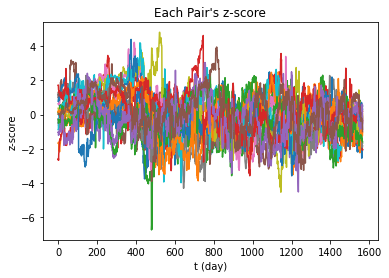

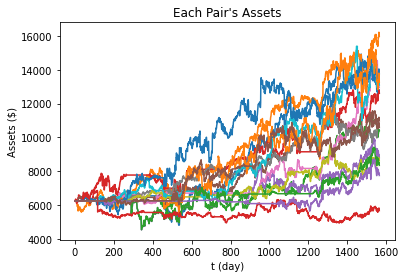

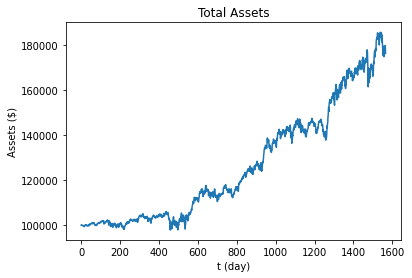

Total earning ratio: 1.7618410842999996


In [77]:
# Read the z-score history list.
with open('z_score_history.npy', 'rb') as infile:
    z_score_list = np.load(infile)
    z_score_list = z_score_list[:len(pairs_list)]

# Remove the initial 700 data. We generate the z-score after 700 days.
price_list = training_set_price.to_numpy()[:, 700:]

# Initial money is $100000.
initial_money = 100000

# Run the backtesting code
BT = Backtesting(z_score_list, total_money = initial_money)
property_per_pair = BT.backtesting(z_score_list, price_list)

# Plot the graphs about results
x = np.arange(z_score_list.shape[1])

# Graph about each pair's z-score
plt.title('Each Pair\'s z-score')
plt.ylabel('z-score')
plt.xlabel('t (day)')
for i in range(len(pairs_list)):
    fig = plt.plot(x, z_score_list[i])
plt.savefig('each_pair_z_score.png')
plt.show()

# Graph about each pair's assets
plt.title('Each Pair\'s Assets')
plt.ylabel('Assets ($)')
plt.xlabel('t (day)')
for i in range(len(pairs_list)):
    plt.plot(x, property_per_pair[i])
plt.savefig('each_pair_assets.png')
plt.show()

# Graph about total property
plt.title('Total Assets')
plt.ylabel('Assets ($)')
plt.xlabel('t (day)')
total_property = np.sum(property_per_pair, axis=0)
plt.plot(x, total_property)
plt.savefig('total_assets.png')
plt.show()

total_earning_ratio = total_property[-1] / initial_money
print("Total earning ratio: " + str(total_earning_ratio))